In [43]:
from datetime import datetime
import numpy as np
import pandas as pd
import matplotlib.pylab as plt
%matplotlib inline
from statsmodels.tsa.stattools import adfuller
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from matplotlib.pylab import rcParams
from pmdarima.arima import auto_arima
rcParams['figure.figsize']=10,6

In [35]:
df_air_passangers_data = pd.read_csv("AirPassengers.csv")

df_air_passangers_data.tail()

,Month,#Passengers
139,1960-08,606
140,1960-09,508
141,1960-10,461
142,1960-11,390
143,1960-12,432


In [36]:
df_air_passangers_data['Month']=pd.to_datetime(df_air_passangers_data['Month'])

In [37]:
df_air_passangers_data.set_index('Month',inplace=True)

In [38]:
df_air_passangers_data.describe()

,#Passengers
count,144.000000
mean,280.298611
std,119.966317
min,104.000000
25%,180.000000
50%,265.500000
75%,360.500000
max,622.000000


In [39]:
df_air_passangers_data.rename(columns={'#Passengers':'Passengers'},inplace=True)

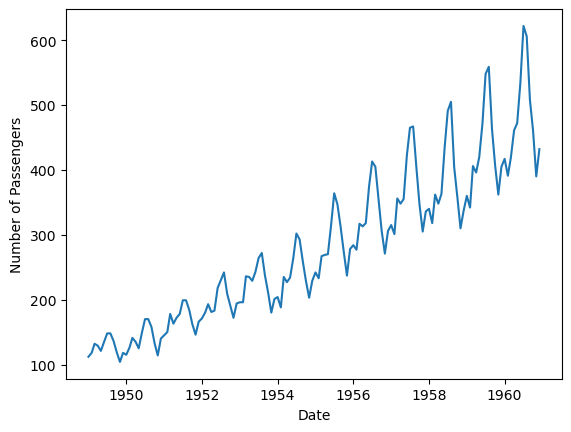

In [40]:
#visualize the data
plt.xlabel('Date')
plt.ylabel('Number of Passengers')
plt.plot(df_air_passangers_data)

In [44]:
#create train and split dataset
train=df_air_passangers_data.Passengers[:int (len(df_air_passangers_data.Passengers)*0.75)] #split dataset into 75/25%
test=df_air_passangers_data.Passengers[int(len(df_air_passangers_data.Passengers)*0.75):]

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=988.670, Time=0.10 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=1002.826, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=996.373, Time=0.04 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=991.646, Time=0.06 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=1001.531, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.20 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.18 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=989.104, Time=0.07 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=991.749, Time=0.07 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=959.218, Time=0.24 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.28 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.22 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.26 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=0.35 sec
 ARIMA(2

C:\Users\User\anaconda3\lib\site-packages\statsmodels\graphics\gofplots.py:993: UserWarning: marker is redundantly defined by the 'marker' keyword argument and the fmt string "bo" (-> marker='o'). The keyword argument will take precedence.
  ax.plot(x, y, fmt, **plot_style)


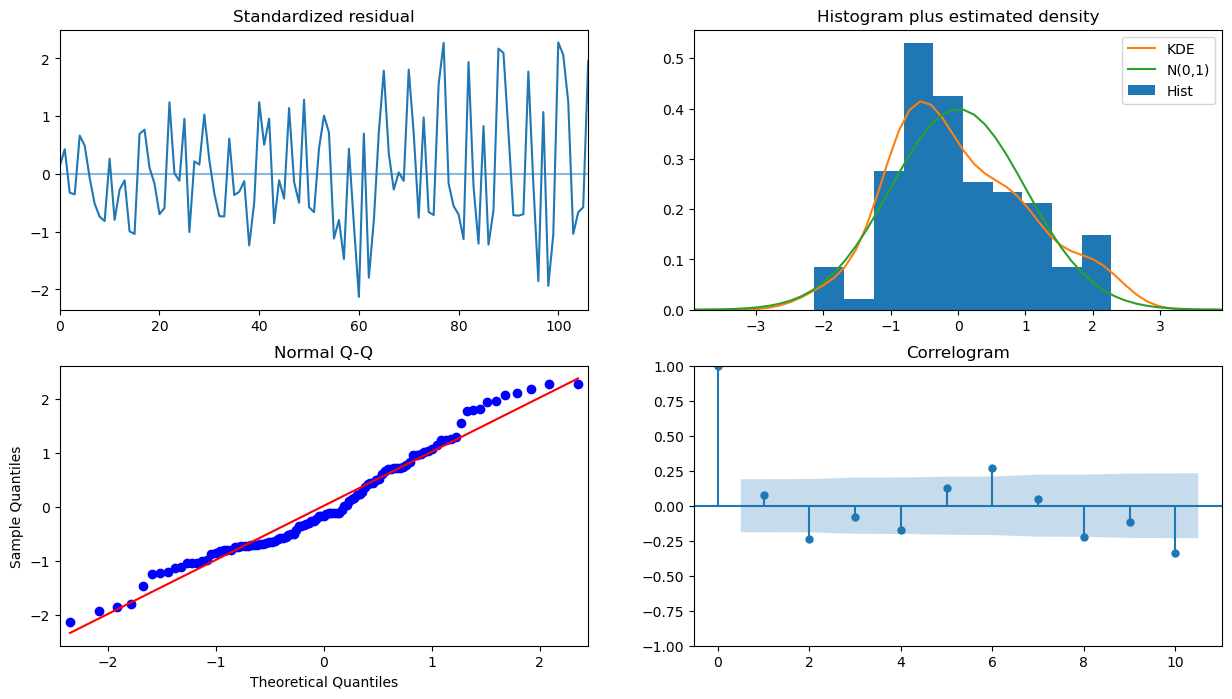

In [45]:
#use autoarima to obtain values of p,d, and q
model_autoARIMA=auto_arima(train, start_p=1,start_q=1,max_p=4,max_q=4,test='adf',m=1, d=1, seasonal=False, trace=True, D=0, error_action='ignore',suppress_warning=True,stepwise=True)
print(model_autoARIMA.summary())
model_autoARIMA.plot_diagnostics(figsize=(15,8))
plt.show()

In [46]:
#forecast
def forecasts(model,actual):
    fc, conf=model.predict(n_periods=len(actual),return_conf_int=True)
    fc_series=pd.Series(fc, index=test.index)
    lower_bound=pd.Series(conf[:,0],index=actual.index)
    upper_bound=pd.Series(conf[:,1],index=actual.index)
    #plot
    plt.plot(df_air_passangers_data.Passengers)
    plt.plot(actual, color='orange', label='actual')
    plt.plot(fc_series,color='green', label='Forecasts')
    plt.fill_between(lower_bound.index, lower_bound, upper_bound, color='k',alpha=.15)
    plt.legend(loc='upper left')
    plt.xlabel('Date')
    plt.ylabel('Number of Passengers')
    plt.title("Forecast of AirPassengers")

    plt.show()

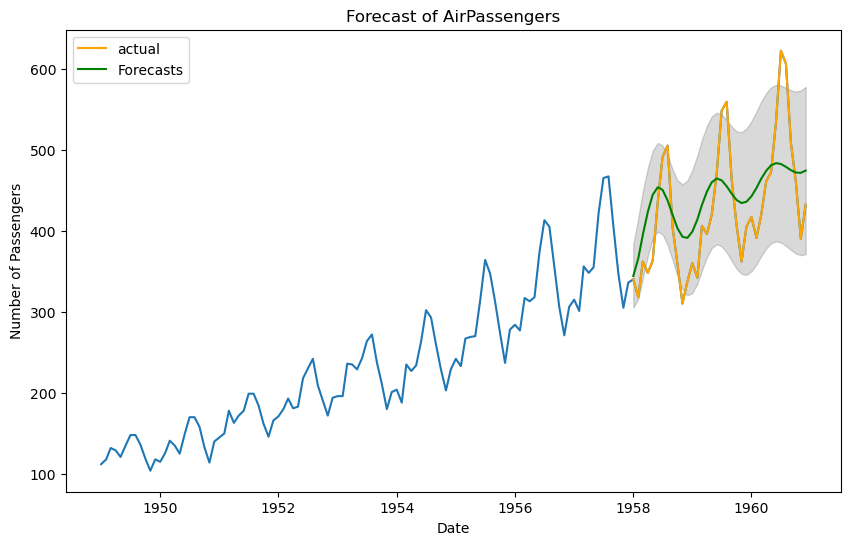

In [47]:
forecasts(model_autoARIMA,test)

In [48]:
#model accuracy
def measure_performance(forecast,actual):
    #mean error
    ME= np.mean(forecast-actual)
    #Mean Absolute Percentage error
    MAPE=np.mean(np.abs(forecast-test)/np.abs(actual))
    #mean percentage error
    MPE=np.mean((forecast-actual)/actual)
    # Lag 1 Autocorrelationn Error
    acf_error=acf(forecast-actual)[1]
    #mean squared error
    MSE=mean_squared_error(actual,forecast)
    #Correlation
    corr=np.corrcoef(forecast, actual)[0,1]
    df_performance=pd.Series([ME,MAPE,MPE,corr,acf_error,MSE],index=['Mean Error','Mean Absolute Percentage Error','Mean Percentage Error','Correlation','Lag 1 Autocorrelationn Error','Mean Squared Error'])
    return df_performance

In [49]:
fc, conf=model_autoARIMA.predict(n_periods=len(test),return_conf_int=True)
forecastArima_series=pd.Series(fc, index=test.index)
measure_performance(forecastArima_series,test)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Mean Error                          11.984790
Mean Absolute Percentage Error       0.116542
Mean Percentage Error                0.049331
Correlation                          0.737414
Lag 1 Autocorrelationn Error         0.665656
Mean Squared Error                3505.368114
dtype: float64

In [50]:
model_Sarima=auto_arima(train, start_p=1,start_q=1,max_p=4,max_q=4,test='adf',m=12, d=None, seasonal=True, trace=True,start_P=1, D=1, error_action='ignore',suppress_warning=True,stepwise=True)
forecast_sm,conf=model_Sarima.predict(n_periods=len(test),return_conf_int=True)
sm_forecast=pd.Series(forecast_sm, index=test.index)

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(1,1,1)[12]             : AIC=707.158, Time=0.16 sec
 ARIMA(0,1,0)(0,1,0)[12]             : AIC=707.730, Time=0.01 sec
 ARIMA(1,1,0)(1,1,0)[12]             : AIC=704.186, Time=0.06 sec
 ARIMA(0,1,1)(0,1,1)[12]             : AIC=704.801, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12]             : AIC=704.001, Time=0.02 sec
 ARIMA(1,1,0)(0,1,1)[12]             : AIC=704.472, Time=0.07 sec
 ARIMA(1,1,0)(1,1,1)[12]             : AIC=705.993, Time=0.16 sec
 ARIMA(2,1,0)(0,1,0)[12]             : AIC=705.691, Time=0.03 sec
 ARIMA(1,1,1)(0,1,0)[12]             : AIC=705.081, Time=0.04 sec
 ARIMA(0,1,1)(0,1,0)[12]             : AIC=704.376, Time=0.02 sec
 ARIMA(2,1,1)(0,1,0)[12]             : AIC=707.075, Time=0.07 sec
 ARIMA(1,1,0)(0,1,0)[12] intercept   : AIC=705.875, Time=0.05 sec

Best model:  ARIMA(1,1,0)(0,1,0)[12]          
Total fit time: 0.794 seconds


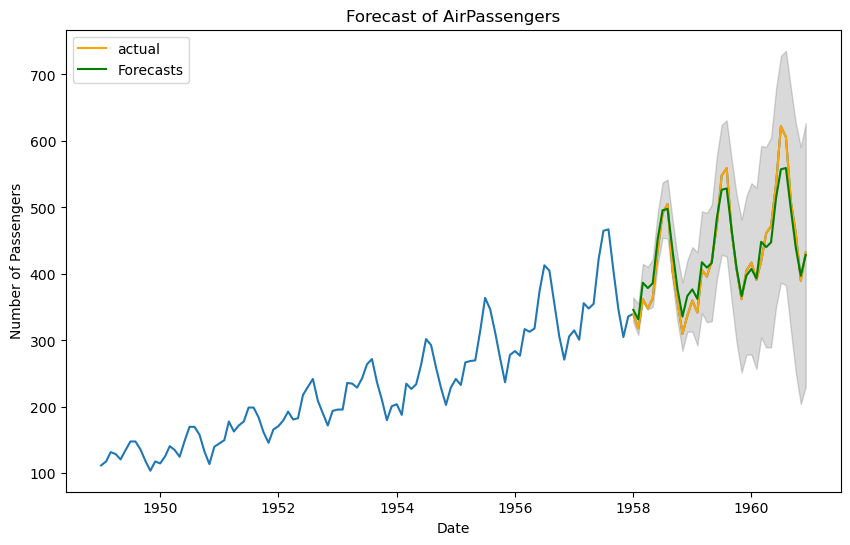

In [51]:
forecasts(model_Sarima,test)

In [52]:
measure_performance(sm_forecast,test)

C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:657: FutureWarning: The default number of lags is changing from 40 tomin(int(10 * np.log10(nobs)), nobs - 1) after 0.12is released. Set the number of lags to an integer to  silence this warning.
  warnings.warn(
C:\Users\User\anaconda3\lib\site-packages\statsmodels\tsa\stattools.py:667: FutureWarning: fft=True will become the default after the release of the 0.12 release of statsmodels. To suppress this warning, explicitly set fft=False.
  warnings.warn(


Mean Error                          1.483445
Mean Absolute Percentage Error      0.041490
Mean Percentage Error               0.010800
Correlation                         0.980477
Lag 1 Autocorrelationn Error        0.616350
Mean Squared Error                489.835902
dtype: float64